In [1]:
import sys 
import numpy as np
import torch
import torchvision

sys.path.append('../firedetect')
from dataset import load_dataset

In [7]:
model = torch.load('../weights/resnet18-epoch-1-valid_acc=0.9809-test_acc=0.9436.pt')


dataset_paths = {'mine': '../data/fire_aerial2k_dataset/',
                 'dunnings': '../data/fire-dataset-dunnings/images-224x224/train/',
                 'dunnings_test': '../data/fire-dataset-dunnings/images-224x224/test/',
                 'furg_test': '../data/fire-dataset-dunnings/images-224x224/test_furg/'}

In [3]:
def accuracy_gpu(pred, truth):
    agreeing = pred.eq(truth)
    acc = agreeing.sum().double()/agreeing.numel()
    return float(acc)

In [8]:
import torch
import torchvision

tr = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                            torchvision.transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root=dataset_paths['furg_test'],
                                                transform=tr)

# test_dataset.class_to_idx = {'fire': 1, 'nofire': 0} # for dunnings

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=0,
    shuffle=True
)

device = torch.device("cuda:0")
test_acc = []

s_list = [] # score list
l_list = [] # label list

model.eval() # evaluation mode (changes behavior of dropout and batchnorm)

with torch.no_grad():
    model = model.to(device)

    for i, data in enumerate(test_loader):
         print(f'testing batch {i}/{len(test_loader)}')
        inputs = data[0].to(device)
        labels = torch.tensor(data[1], dtype=torch.bool).to(device)

        scores = model(inputs).squeeze()
        
        s_list += list(scores.to('cpu').numpy())
        l_list += list(labels.to('cpu').numpy())
#         pred = scores > 0.5

#         a = accuracy_gpu(pred, labels)
#         test_acc.append(a)


scores = np.array(s_list)
truth = np.array(l_list)

/home/tomek/anaconda3/envs/fire-detect/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Let's plot ROC curve

In [11]:
import sklearn.metrics 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(truth, scores)

No handles with labels found to put in legend.


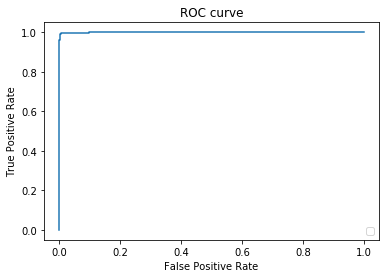

In [12]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Let's find maximal accuracy

In [13]:
accs = []
for t in thresholds:
    pred = scores > t
    a = sklearn.metrics.accuracy_score(truth, pred)
    accs.append(a)

In [14]:
thresholds[np.array(accs).argmax()]

0.77087384

In [16]:
pred = scores > 0.625
precision, recall, fscore, _ = sklearn.metrics.precision_recall_fscore_support(truth, pred, average='binary')

In [17]:
recall

0.9964058612109483

In [18]:
precision

0.986046511627907

In [19]:
fscore

0.9911991199119914